In [82]:
library(data.table)
library(ggplot2)
library(lme4)
library(parallel)

theme_set(theme_bw())

## Prepare Data

In [37]:
literacy.covariates.data <- data.table(id=c(1:91))
literacy.covariates.data[,base.age:=1 + 0.1*(id - 1)]
literacy.covariates.data[,`0`:=base.age]
literacy.covariates.data[,`1`:=`0` + (1 + (10 - base.age)/10)^2]
literacy.covariates.data[,`2`:=`1` + (1 + (10 - base.age)/10)^2]
literacy.covariates.data <- melt(literacy.covariates.data, id.vars=c('id', 'base.age'),
                                 value.name='total.age', variable.name='follow.per')
literacy.covariates.data[,follow.per:=as.numeric(follow.per) - 1]
setkey(literacy.covariates.data, id, follow.per)
literacy.covariates.data[,delta.age:=total.age - base.age]
literacy.covariates.data

id,base.age,follow.per,total.age,delta.age
1,1.0,0,1.0000,0.0000
1,1.0,1,4.6100,3.6100
1,1.0,2,8.2200,7.2200
2,1.1,0,1.1000,0.0000
2,1.1,1,4.6721,3.5721
2,1.1,2,8.2442,7.1442
3,1.2,0,1.2000,0.0000
3,1.2,1,4.7344,3.5344
3,1.2,2,8.2688,7.0688
4,1.3,0,1.3000,0.0000


## Visualization

png 
  2

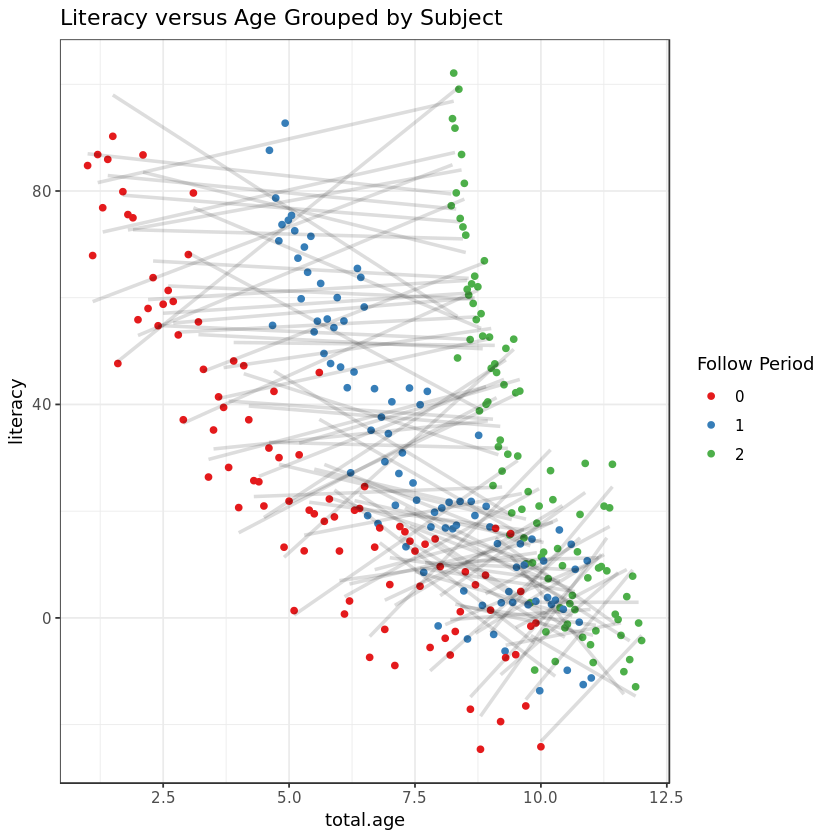

In [83]:
make.response <- function(covariates, variance=100) {
    (10 - covariates$base.age)^2 + covariates$delta.age + rnorm(n=nrow(covariates), sd=sqrt(variance))
}

set.seed(2020)
literacy.data <- copy(literacy.covariates.data)
literacy.data[,literacy:=make.response(literacy.data)]

p <- ggplot(literacy.data, aes(x=total.age, y=literacy)) +
  geom_point(aes(color=as.factor(follow.per))) +
  scale_color_brewer('Follow Period', palette='Set1') + 
  #geom_line(aes(group=id), alpha=0.125) +
  geom_smooth(aes(group=id), method='lm', se=FALSE, color='#00000022') +
  ggtitle('Literacy versus Age Grouped by Subject')

pdf('literacy_versus_age.pdf', width=6, height=4)
p
dev.off()
p